Here we train a neural network on data from data_generation_dynamics_simulation and demonstrate quantum error mitigation. Echo-evolution (training data) has time points $t \in [0,...,\pi/2]$ and forward-in-time evolution (test data) has time points $ t \in [0,...,\pi]$

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import importlib
import os
from sklearn.model_selection import train_test_split

import torch
from torch import nn
from torch import optim
from torchsummary import summary

import nn_functions
importlib.reload(nn_functions)
import functions as func
importlib.reload(func)

<module 'functions' from 'c:\\Users\\miPro\\code\\Quantum computing\\neural_network_error_mitigation\\paper_code\\functions.py'>

### Upload data

In [29]:
cwd = os.getcwd()

#new_dir = cwd + '/data_q_000_J_half_h'
#new_dir = cwd + '/data_q_003_J_half_h'
#new_dir = cwd + '/data_q_007_J_half_h'
new_dir = cwd + '/data_q_01_J_half_h'
#new_dir = cwd + '/data_q_011_J_half_h'
#new_dir = cwd + '/data_q_012_J_half_h'
#new_dir = cwd + '/data_q_013_J_half_h'

#### Echo-evolution data

In [30]:
"""
data['data'].shape = (number of initial states, number of time points, noise-free(0) or noisy(1), number of spins)
"""

data_name = '/data_t_5'

with open(new_dir + data_name + '.pkl', 'rb') as f:
    train_data_loaded = pickle.load(f)
    
del train_data_loaded['parameters']['init state']

#### Forward-in-time evolution data

In [31]:
data_name = '/test_data_10_trotters_T'

T_postfix = data_name.split('_')[-1]

with open(new_dir + data_name + '.pkl', 'rb') as f:
    test_data_loaded = pickle.load(f)
    
del test_data_loaded['parameters']['init state']

In [33]:
import pprint

pprint.pprint(train_data_loaded['parameters'])
pprint.pprint(test_data_loaded['parameters'])

print("Number of operations:")
pprint.pprint(train_data_loaded['parameters']['circuit'].count_ops())
pprint.pprint(test_data_loaded['parameters']['circuit'].count_ops())

"""
data['data'].shape = (number of initial states, number of time points, noise-free(0) or noisy(1), number of spins)
"""
# Echo-evolution data shape
print(train_data_loaded['data'].shape)
# Forward-in-time-evolution data shape
print(test_data_loaded['data'].shape)

{'J values': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 'backend': QasmSimulator('qasm_simulator'),
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000271B84276D0>,
 'coupling map': [[0, 1], [0, 2], [1, 3], [3, 2], [2, 4], [3, 5], [4, 5]],
 'h values': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'num of qubits': 6,
 'num of trotters': 10,
 'p threshold': 0.8,
 'time points': 5,
 'total sim time': 3.141592653589793}
{'J values': [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
 'backend': QasmSimulator('qasm_simulator'),
 'circuit': <qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x00000271FC76D490>,
 'coupling map': [[0, 1], [0, 2], [1, 3], [3, 2], [2, 4], [3, 5], [4, 5]],
 'h values': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'num of qubits': 6,
 'num of trotters': 10,
 'p threshold': 0.8,
 'time points': 20,
 'total sim time': 3.141592653589793}
Number of operations:
OrderedDict([('barrier', 361),
             ('cx', 280),
             ('rz', 140),
             ('rx', 120),
             (

In [35]:
# Convert qubit excitation to spin magnetization
X = train_data_loaded['data'][:,:,1,:]
X = 2*X - 1
y = train_data_loaded['data'][:,:,0,:]
y = 2*y - 1

# Upload time points
time_points = np.linspace(0, train_data_loaded['parameters']['total sim time'], train_data_loaded['parameters']['time points'])
tn = X.shape[1] # number of time points

# Expand data from different data points
X_new = []
for k in range(X.shape[1]):
    X_new += [*X[:,k,:]]
X_new = np.array(X_new)
X = X_new

y_new = []
for k in range(y.shape[1]):
    y_new += [*y[:,k,:]]
y_new = np.array(y_new)
y = y_new

# Divide data into train and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.1666)
X_train_val = torch.from_numpy(X_train_val)
X_test  = torch.from_numpy(X_test)
y_train_val = torch.from_numpy(y_train_val)
y_test  = torch.from_numpy(y_test)

# Divide training data into training and validation sets
valid_size = 0.2
num_train_val = len(X_train_val)
indices = list(range(num_train_val))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train_val))
train_idx, valid_idx = indices[split:], indices[:split]

X_train = X_train_val[train_idx]    
y_train = y_train_val[train_idx]

X_valid = X_train_val[valid_idx]    
y_valid = y_train_val[valid_idx]
    
print("data shape: ", train_data_loaded['data'].shape)
print(X.shape, X_train.shape, X_valid.shape, X_test.shape)
print(y.shape, y_train.shape, y_valid.shape, y_test.shape)

k = 0

print("Noisy data vector t:    ", X_train[k])
print("Noise-free data vector t: ", y_train[k])

data shape:  (2400, 5, 2, 6)
(12000, 6) torch.Size([8000, 6]) torch.Size([2000, 6]) torch.Size([2000, 6])
(12000, 6) torch.Size([8000, 6]) torch.Size([2000, 6]) torch.Size([2000, 6])
Noisy data vector t:     tensor([-0.2426, -0.0846,  0.0018,  0.0312,  0.0998, -0.1640],
       dtype=torch.float64)
Noise-free data vector t:  tensor([-0.7606, -0.2776,  0.1232,  0.0790,  0.6360, -0.6960],
       dtype=torch.float64)


### Neural network

In [10]:
import nn_functions
importlib.reload(nn_functions)

D_in = X_train[0].shape[0]
D_hidden = 200

model     = nn_functions.generate_onelayer_model(D_in, D_hidden, out_f='tanh')
model_name = f'spin_model_t{tn}_Dh_{D_hidden}_{T_postfix}'

if not os.path.isdir(new_dir + '/' + model_name):
    os.mkdir(new_dir + '/' + model_name)

summary(model, (6, ))

Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 200]                 1,400
├─LeakyReLU: 1-2                         [-1, 200]                 --
├─Linear: 1-3                            [-1, 200]                 40,200
├─LeakyReLU: 1-4                         [-1, 200]                 --
├─Linear: 1-5                            [-1, 6]                   1,206
├─Tanh: 1-6                              [-1, 6]                   --
Total params: 42,806
Trainable params: 42,806
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17


c:\Users\miPro\anaconda3\lib\site-packages\torch\cuda\__init__.py:107: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\c10\cuda\CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Layer (type:depth-idx)                   Output Shape              Param #
├─Linear: 1-1                            [-1, 200]                 1,400
├─LeakyReLU: 1-2                         [-1, 200]                 --
├─Linear: 1-3                            [-1, 200]                 40,200
├─LeakyReLU: 1-4                         [-1, 200]                 --
├─Linear: 1-5                            [-1, 6]                   1,206
├─Tanh: 1-6                              [-1, 6]                   --
Total params: 42,806
Trainable params: 42,806
Non-trainable params: 0
Total mult-adds (M): 0.04
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.16
Estimated Total Size (MB): 0.17

### Train neural network

In [314]:
lr_0 = 3e-4
optimizer = optim.Adam(model.parameters(), lr=lr_0)
criterion = nn.MSELoss()
N_batches = 80
batch_size = int(X_train.shape[0]/N_batches)
print(batch_size)
epochs = 100     

25


In [315]:
train_losses, valid_losses = [], []

valid_loss_min = np.Inf 

model.double()

for epoch in range(epochs):
    
    # Shuffle training set
    num_train = len(X_train)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    X_train = X_train[indices]
    y_train = y_train[indices]
    # Shuffle validation set
    num_valid = len(X_valid)
    indices = list(range(num_valid))
    np.random.shuffle(indices)
    X_valid = X_valid[indices]
    y_valid = y_valid[indices]    
        
    train_loss = 0.0
        
    for i in range(N_batches):
        
        x, y = X_train[i*batch_size:(i+1)*batch_size, :], y_train[i*batch_size:(i+1)*batch_size, :]
        
        optimizer.zero_grad()
        y_ = model(x)
        loss = criterion(y, y_)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()    
    
    else:
        valid_loss = 0.0
        with torch.no_grad():
            for x, y in zip(X_valid, y_valid):
                
                y_ = model(x)
                loss = criterion(y, y_)
                valid_loss += loss.item()
            
    train_losses.append(train_loss/N_batches)
    valid_losses.append(valid_loss/len(X_valid)) 
        
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch+1, 
        train_loss/N_batches,
        valid_loss/len(X_valid)
        ))
    
    if valid_loss/len(X_valid) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss/len(X_valid)))
        torch.save(model.state_dict(), new_dir + '/' + model_name + f'/model_{epochs}_epochs.pt')
        valid_loss_min = valid_loss/len(X_valid)

Epoch: 1 	Training Loss: 0.710658 	Validation Loss: 0.683290
Validation loss decreased (inf --> 0.683290).  Saving model ...
Epoch: 2 	Training Loss: 0.665697 	Validation Loss: 0.637568
Validation loss decreased (0.683290 --> 0.637568).  Saving model ...
Epoch: 3 	Training Loss: 0.619564 	Validation Loss: 0.591437
Validation loss decreased (0.637568 --> 0.591437).  Saving model ...
Epoch: 4 	Training Loss: 0.573997 	Validation Loss: 0.546730
Validation loss decreased (0.591437 --> 0.546730).  Saving model ...
Epoch: 5 	Training Loss: 0.531487 	Validation Loss: 0.506698
Validation loss decreased (0.546730 --> 0.506698).  Saving model ...
Epoch: 6 	Training Loss: 0.493824 	Validation Loss: 0.472116
Validation loss decreased (0.506698 --> 0.472116).  Saving model ...
Epoch: 7 	Training Loss: 0.461525 	Validation Loss: 0.442585
Validation loss decreased (0.472116 --> 0.442585).  Saving model ...
Epoch: 8 	Training Loss: 0.433767 	Validation Loss: 0.417279
Validation loss decreased (0.44258

[]

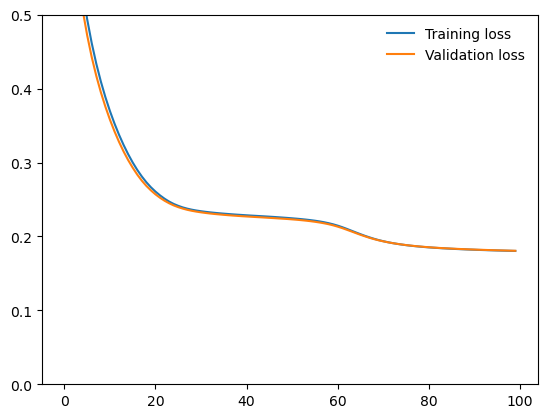

In [316]:
# Графики
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)
plt.ylim(0.0, 0.5)

plt.plot()